# What is CLTV (Customer Life Time Value)?¶

- Customer lifetime value (CLTV), represents the total amount of money a customer is expected to spend in your business, or on your products, during their lifetime.
- Focusing on CLTV helps you design an efficient strategy with concise budget planning. However, some customers bring your business more value than the others. That’s why it’s crucial to know which ones you should focus on first and invest in.
- With CLTV calculation, you can take a picture of today, but with CLTV prediction, you make time projections such as 3 months, 1 year.

**BG/NBD (Beta Geometric / Negative Binomial Distribution) Model** will model each customer’s purchase behaviours’ distribution and will predict the expected number of transactions for each customer. It is also known as “Buy Till You Die” Model.

**BG/NBD model, models 2 processes as**

- **Transaction Process (Buy)**
- During the customer is alive, the number of will have made by the customer, will be distributed poison by transaction rate parameter
- During the customer is alive, they will be purchasing around their own transaction rate
- Transaction rates will change for each customer and they will be distributed gamma (r,α)

- **Dropout Process (Till You Die)**
- Each customer has their own dropout rate by p probability
- The customer will be a dropout by p probability
- Dropout rates will change for each customer and they will be distributed beta (a,b) for the mass

**Gamma-Gamma Submodel** will model the expected average profit distribution and will predict the expected average profit for each customer.

# Customer Lifetime Value Calculation¶
- Our goal is to identify the customers who can generate the most revenue in certain time periods (1 week, 1 month, 3 months, 6 months, 1 year).
- It will be designed accordingly and will be created according to this particular clustering.
- FLO, Wants to determine marketing strategies according to these segments.
- Segmenting the customers of FLO, an online shoe store, wants to make sense according to these segments.


# Road Map¶

- Data Preparation
- Expected Number of Transaction with BG-NBD Model
- Expected Average Profit with Gamma-Gamma Model
- Calculation of CLTV with BG-NBD and Gamma-Gamma Model
- Creation of Segments According to CLTV

# Business Problem
- FLO would like to set a roadmap for sales and marketing activities. In order for the company to make a medium-long-term plan, it is necessary to estimate the potential value that existing customers will provide to the company in the future. 
- Calculating Customer Life Time Value values for each customer, then segmenting customers according to these customer life time values.

# Data Story¶
- The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) in the years 2020-2021.

- **master_id:** Unique customer ID
- **order_channel:** Used channel for shopping(Android, iOS, Desktop, Mobile)
- **last_order_channel:** The channel where the most recent purchase was made
- **first_order_date:** Date of the customer's first purchase
- **last_order_date:** Date of the customer's last purchase
- **last_order_date_online:** The date of the last purchase made by the customer on the online platform
- **last_order_date_offline:** The date of the last purchase made by the customer on the offline platform
- **order_num_total_ever_online:** The total number of purchases made by the customer on the online platform
- **order_num_total_ever_offline:** The total number of purchases made by the customer on the offline platform
- **customer_value_total_ever_online:** The total payment by the customer for their online shopping
- **customer_value_total_ever_offline:** The total payment by the customer for their offline shopping
- **interested_in_categories_12:** List of categories the customer has shopped in the last 12 months

In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.4 MB/s eta 0:00:00


In [2]:
# import Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

warnings.simplefilter(action="ignore")

In [3]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

In [4]:
# Loading the Data Set
df = pd.read_csv('/kaggle/input/dataset/flo_data_20k.csv')


In [5]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [6]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

In [7]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 19945
Variables: 12
cat_cols: 2
num_cols: 4
cat_but_car: 6
num_but_cat: 0


In [8]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


- **Note:** When calculating cltv, frequency values must be integer, so round the lower and upper limits with round().

In [9]:
# The lower and upper limits of outliers were determined.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [10]:
# We rounded the lower and upper values. We cropped according to max and min values.

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)


In [11]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [12]:
# numeric_cols = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"]
#for col in numeric_cols:
#   replace_with_thresholds(df, col)

In [13]:
df["total_order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [14]:
# We have changed the type of date expressing variables to date.

for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# Creating CLTV Data Structure
- 1. We took 2 days after the date of the last purchase in the dataset as the analysis date.
- 2. We created a new cltv dataframe with customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg.
- 3. The monetary value will be expressed as the average value per purchase, while the recency and tenure values will be expressed in weekly terms.

- **recency:** Time since the last purchase. Weekly (user specific)
- **T:** Age of the customer. Weekly (how long before the date of analysis was the first purchase)
- **frequency:** total number of repeat purchases (frequency>1)
- **monetary:** average earnings per purchase

In [16]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [17]:
# Present Date (date of analysis)

today_date = dt.datetime(2021, 6, 1)

In [18]:
today_date

datetime.datetime(2021, 6, 1, 0, 0)

In [19]:
cltv_df = df[["master_id", "last_order_date", "first_order_date", "total_order", "total_value"]]

In [20]:
cltv_df.head()

,master_id,last_order_date,first_order_date,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800


In [21]:
cltv_df.rename(columns={"master_id": "customer_id"}, inplace=True)

In [22]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,total_order,total_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800


In [23]:
# We converted the recency value to weekly.

cltv_df["recency_weekly"] = (cltv_df["last_order_date"] - cltv_df["first_order_date"]).dt.days/7

In [24]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,total_order,total_value,recency_weekly
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700,17.0000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500,209.8571
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200,52.2857
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700,1.5714
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800,83.1429


In [25]:
# We translated the age of the customer on a weekly basis. 

cltv_df["T_weekly"] = (today_date - cltv_df["first_order_date"]).dt.days/7

In [26]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,total_order,total_value,recency_weekly,T_weekly
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700,17.0000,30.5714
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500,209.8571,224.8571
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200,52.2857,78.8571
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700,1.5714,20.8571
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800,83.1429,95.4286


In [27]:
cltv_df.rename(columns={"total_order": "frequency"}, inplace=True)

In [28]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,frequency,total_value,recency_weekly,T_weekly
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700,17.0000,30.5714
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500,209.8571,224.8571
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200,52.2857,78.8571
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700,1.5714,20.8571
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800,83.1429,95.4286


In [29]:
cltv_df = cltv_df[cltv_df["frequency"] > 1]

In [30]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,frequency,total_value,recency_weekly,T_weekly
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700,17.0000,30.5714
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500,209.8571,224.8571
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200,52.2857,78.8571
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700,1.5714,20.8571
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800,83.1429,95.4286


In [31]:
cltv_df["monetary_avg"] = cltv_df["total_value"] / cltv_df["frequency"]

In [32]:
cltv_df.head()

,customer_id,last_order_date,first_order_date,frequency,total_value,recency_weekly,T_weekly,monetary_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0000,939.3700,17.0000,30.5714,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0000,2013.5500,209.8571,224.8571,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0000,585.3200,52.2857,78.8571,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0000,121.9700,1.5714,20.8571,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0000,209.9800,83.1429,95.4286,104.9900


In [33]:
cltv_df = cltv_df[["customer_id", "recency_weekly", "T_weekly", "frequency", "monetary_avg"]]

In [34]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900


In [35]:
#df["recency"] = df["last_order_date"]-df["first_order_date"]

# cltv_df = df.groupby("master_id").agg({"recency": [lambda InvoiceDate: (InvoiceDate.max()).days],"first_order_date": [lambda recency: (today_date - recency.max()).days],
                              # "TotalPurchase": "sum",
                              #  "TotalPrice": "sum"})

# Establishing BG-NBD Model

In [36]:
# Created model object

bgf = BetaGeoFitter(penalizer_coef=0.001)

In [37]:
# Model fitting

bgf.fit(cltv_df["frequency"],
        cltv_df["recency_weekly"],
        cltv_df["T_weekly"])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

# In 1 Months, What is the Expected Number of Sales for the Whole Company??

In [38]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency_weekly'],
            cltv_df['T_weekly']).sum()

3836.823737990782

In [39]:
# # add to cltv_df (1 month)
cltv_df["expected_purc_1_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_weekly'],
                                               cltv_df['T_weekly'])

In [40]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960


# In 3 Months, What is the Expected Number of Sales for the Whole Company?

In [41]:
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency_weekly'],
            cltv_df['T_weekly']).sum()

11510.471213972345

In [42]:
# add to cltv_df (3 months)

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_weekly'],
                                               cltv_df['T_weekly'])

In [43]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960


# In 6 Months, What is the Expected Number of Sales for the Whole Company?

In [44]:
bgf.predict(4 * 6,
            cltv_df['frequency'],
            cltv_df['recency_weekly'],
            cltv_df['T_weekly']).sum()

23020.942427944694

In [45]:
# add to cltv_df (6 months)

cltv_df["expected_purc_6_month"] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_weekly'],
                                               cltv_df['T_weekly'])

In [46]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960,0.7921


# In 9 Months, What is the Expected Number of Sales for the Whole Company?

In [47]:
bgf.predict(4 * 9,
            cltv_df['frequency'],
            cltv_df['recency_weekly'],
            cltv_df['T_weekly']).sum()

34531.41364191704

In [48]:
# add to cltv_df (9 months)

cltv_df["expected_purc_9_month"] = bgf.predict(4 * 9,
                                               cltv_df['frequency'],
                                               cltv_df['recency_weekly'],
                                               cltv_df['T_weekly'])

In [49]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739,1.9479,2.9218
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832,1.9663,2.9495
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706,1.3412,2.0118
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004,1.4008,2.1012
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960,0.7921,1.1881


# In 1 Year, What is the Expected Number of Sales for the Whole Company?

In [50]:
bgf.predict(4 * 12,
            cltv_df['frequency'],
            cltv_df['recency_weekly'],
            cltv_df['T_weekly']).sum()

46041.88485588938

In [51]:
# add to cltv_df (1 year)

cltv_df["expected_purc_1_year"] = bgf.predict(4 * 12,
                                               cltv_df['frequency'],
                                               cltv_df['recency_weekly'],
                                               cltv_df['T_weekly'])

In [52]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739,1.9479,2.9218,3.8957
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832,1.9663,2.9495,3.9326
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706,1.3412,2.0118,2.6823
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004,1.4008,2.1012,2.8016
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960,0.7921,1.1881,1.5842


# Evaluation of Forecast Results


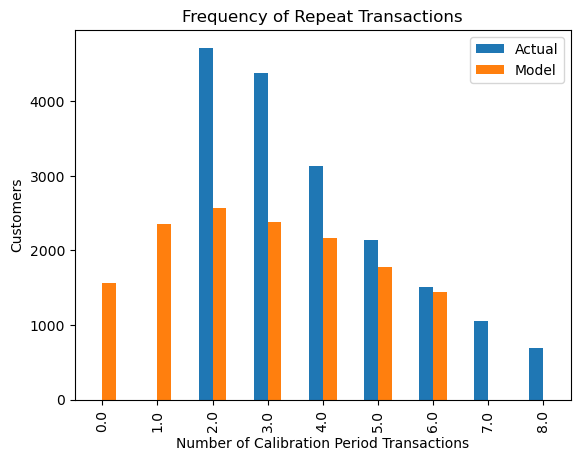

In [53]:
plot_period_transactions(bgf)
plt.show(block=True)

# Establishing the GAMMA-GAMMA Model


In [54]:
# Created model object

ggf = GammaGammaFitter(penalizer_coef=0.01)

In [55]:
# Model fitting

ggf.fit(cltv_df["frequency"], cltv_df["monetary_avg"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [56]:
# add to cltv_df

cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                                                       cltv_df["monetary_avg"])

In [57]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739,1.9479,2.9218,3.8957,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832,1.9663,2.9495,3.9326,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706,1.3412,2.0118,2.6823,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004,1.4008,2.1012,2.8016,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960,0.7921,1.1881,1.5842,114.3251


# Calculation of CLTV with BG-NBD and GG model

In [58]:
cltv_df["clv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency_weekly"],
                                   cltv_df["T_weekly"],
                                   cltv_df["monetary_avg"],
                                   time=6,  # 6 months
                                   freq="W",  # T's frequency information.(weekly)
                                   discount_rate=0.01)

In [59]:
cltv_df.head()

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,exp_average_value,clv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,0.9739,1.9479,2.9218,3.8957,193.6327,395.7332
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,0.9832,1.9663,2.9495,3.9326,96.6650,199.4307
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,0.6706,1.3412,2.0118,2.6823,120.9676,170.2242
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,0.7004,1.4008,2.1012,2.8016,67.3201,98.9455
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.3960,0.7921,1.1881,1.5842,114.3251,95.0117


In [60]:
cltv_df.sort_values("clv", ascending=False).head(20)

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,1.0944,2.1888,3.2832,4.3775,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,1.9701,3.9402,5.9103,7.8804,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,0.7222,1.4445,2.1667,2.8890,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,1.5653,3.1306,4.6959,6.2612,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,4.6561,9.3123,13.9684,18.6246,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,1.2655,2.5309,3.7964,5.0618,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,0.7939,1.5878,2.3818,3.1757,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,2.7807,5.5614,8.3421,11.1228,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,3.0838,6.1676,9.2513,12.3351,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,0.8716,1.7431,2.6147,3.4863,778.0504,1422.9997


# Creation of Segments According to CLTV

In [61]:
# We divided all our 6-month-old customers into 4 groups (segments) and added the group names to the data set.

cltv_df["cltv_segment"] = pd.qcut(cltv_df["clv"], 4, labels=["D", "C", "B", "A"])

In [62]:
cltv_df.sort_values("clv", ascending=False).head(20)

,customer_id,recency_weekly,T_weekly,frequency,monetary_avg,expected_purc_1_month,expected_purc_3_month,expected_purc_6_month,expected_purc_9_month,expected_purc_1_year,exp_average_value,clv,cltv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,1.0944,2.1888,3.2832,4.3775,1449.0605,3327.7770,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,1.9701,3.9402,5.9103,7.8804,767.3606,3172.3944,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,0.7222,1.4445,2.1667,2.8890,1127.6115,1708.9821,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,1.5653,3.1306,4.6959,6.2612,506.1667,1662.6135,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,4.6561,9.3123,13.9684,18.6246,166.7123,1628.8874,A
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,1.2655,2.5309,3.7964,5.0618,611.4926,1623.8127,A
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,0.7939,1.5878,2.3818,3.1757,923.6800,1538.8559,A
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,2.7807,5.5614,8.3421,11.1228,262.0729,1529.2280,A
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,3.0838,6.1676,9.2513,12.3351,229.6069,1485.8192,A
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,0.8716,1.7431,2.6147,3.4863,778.0504,1422.9997,A


In [63]:
cltv_df.groupby("cltv_segment").agg({"clv": ["mean", "min", "max"],
                                     "frequency":["mean", "min", "max", "sum"],
                                     "monetary_avg":["mean", "min", "max", "sum"],
                                     "recency_weekly":["mean", "min", "max"]})

clv                    frequency                            \
                 mean      min       max      mean    min     max        sum   
cltv_segment                                                                   
D             80.3405  12.1080  112.2454    3.7688 2.0000 18.0000 18795.0000   
C            138.3115 112.2484  165.4689    4.4047 2.0000 32.0000 21962.0000   
B            199.5328 165.4692  240.0579    5.0927 2.0000 50.0000 25392.0000   
A            362.3155 240.0854 3327.7770    6.6466 2.0000 57.0000 33140.0000   

             monetary_avg                                recency_weekly  \
                     mean     min       max          sum           mean   
cltv_segment                                                              
D                 93.1516 22.4900  284.9850  464547.0459       139.0002   
C                125.7885 34.3156  342.8400  627181.6473        92.6295   
B                160.6366 50.0426  539.9850  800933.9587        81.9884   
A                228.8311 64.3645 1401.8000 1140952.0746        67.4271   

                              
                min      max  
cltv_segment                  
D            0.0000 432.5714  
C            0.0000 433.0000  
B            0.0000 415.5714  
A            0.0000 433.4286